# Calculating Climate Anomaly

## **Overview**

We will take [monthly soil moisture](https://www.cpc.ncep.noaa.gov/products/Soilmst_Monitoring/Global/Soilmst/gl_soilmst_clim.shtml) data from NOAA Climate Prediction Center and calculate monthly anomalies relative to the 1971-2000 climatology.

Data Credit:

*   [Global Soil Moisture](https://psl.noaa.gov/thredds/catalog/Datasets/cpcsoil/catalog.html). NOAA Climate Prediction Center. Retrieved 2022-09


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !apt-get -qq remove python-shapely python3-shapely
  !pip install --no-binary shapely shapely --force
  !pip install --no-binary cartopy cartopy==0.19.0.post1

In [ ]:
import os
import xarray as xr
import cartopy
import cartopy.crs as ccrs 
import os
import matplotlib.pyplot as plt


In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


filename = 'soilw.mon.mean.v2.nc'
url = 'https://psl.noaa.gov/thredds/fileServer/Datasets/cpcsoil/' + filename

download(url)

# Data Pre-Processing

First we read the raster file using `rioxarray`

In [ ]:
file_path = os.path.join(data_folder, filename)
ds = xr.open_dataset(file_path)
ds

In [ ]:
da = ds.soilw
da

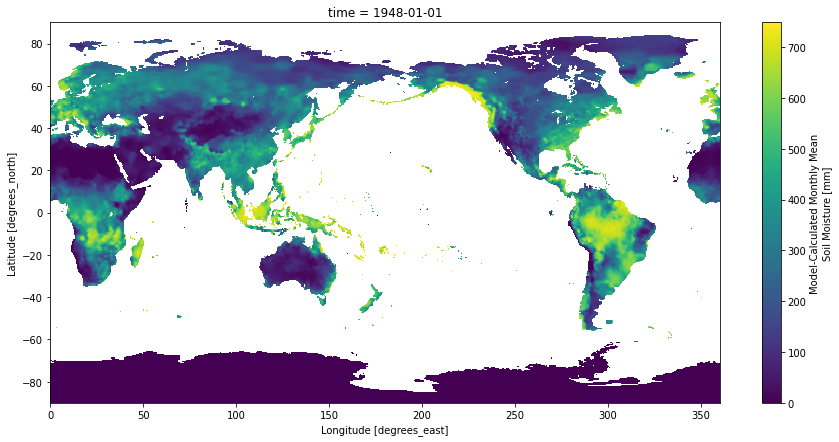

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
da.isel(time=0).plot.imshow(ax=ax)
plt.show()

We transform the date from 0-360 longitude to -180-+180 longitudes

In [22]:
da.coords['lon'] = (da.coords['lon'] + 180) % 360 - 180
da = da.sortby(da.lon)

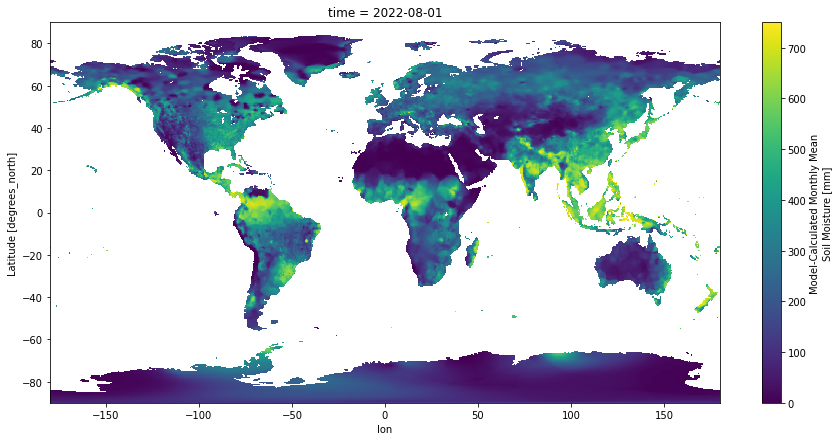

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
da.isel(time=-1).plot.imshow(ax=ax)
plt.show()

Let's calculate soil moisture anomaly for 2021 as defined as the departure relative to the 1971–2000 climatology.

In [24]:
mean = da.sel(time=slice('1971', '2000')).groupby('time.month').mean('time')

In [25]:
anomaly = da.groupby('time.month') - mean

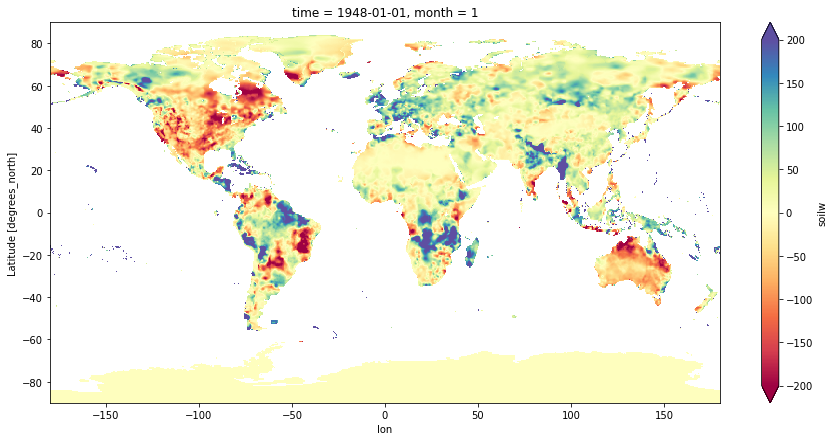

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
anomaly.isel(time=0).plot.imshow(ax=ax, cmap='Spectral', vmin=-200, vmax=200)
plt.show()

We now plot the monthly anomaly for each month of 2021.

In [27]:
anomaly2021 = anomaly.sel(time='2021')

We create a layout with 12 subplots (6 rows and 2 columns). The result will be a 2D NumPy array of Axes for each subplot. To easily iterate over each, use use NumPy's `numpy.ndarray.flat` attribute to get a flattened 1D array. The `enumerate()` function will give us the index of the array along with the Axes object from the array.

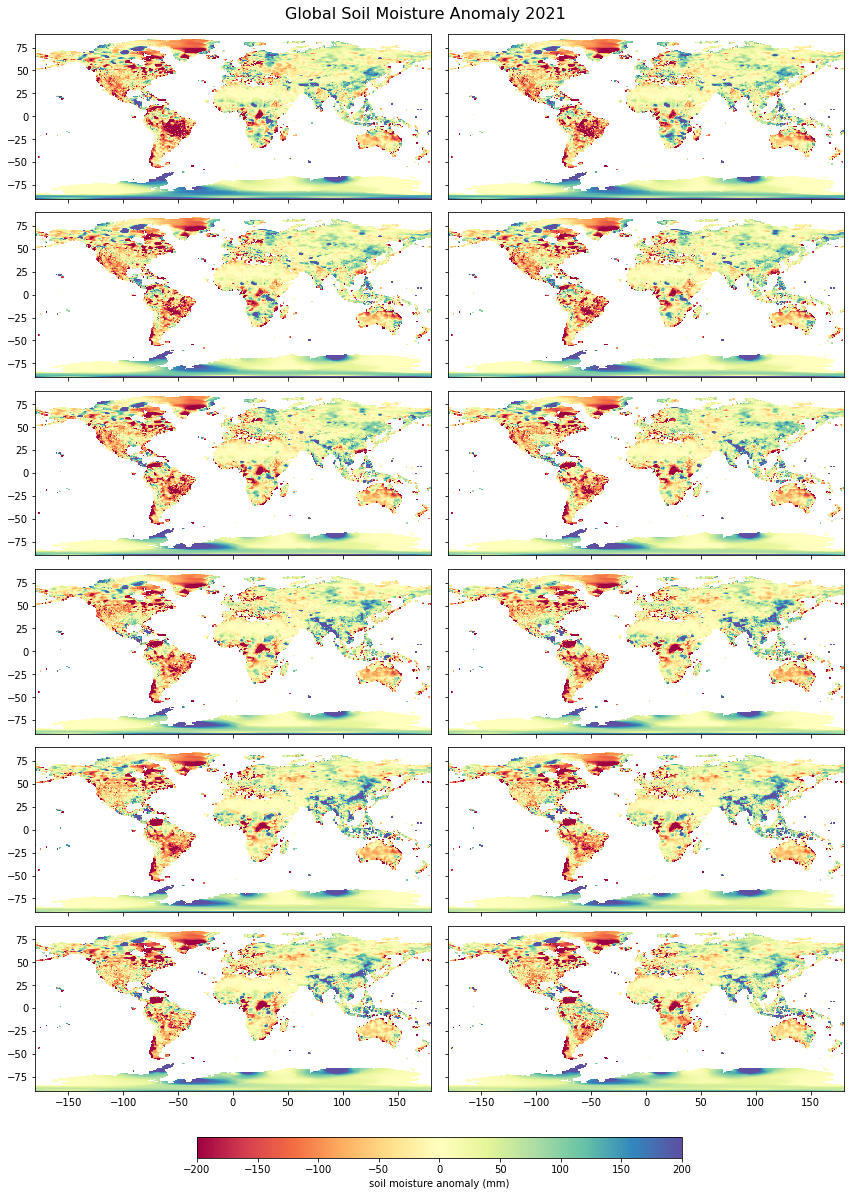

In [28]:
fig, axes = plt.subplots(6, 2, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(11.7, 16.5)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

index = 0
for index, ax in enumerate(axes.flat):
    data = anomaly2021.isel(time=index)
    im = data.plot(ax=ax, cmap='Spectral', vmin=-200, vmax=200, add_colorbar=False, add_labels=False)
    colax.set_title(month_names[index] + ' 2021')
    colax.set_aspect('equal')

    colax.get_xaxis().set_ticklabels([])
    colax.get_yaxis().set_ticklabels([])

# Place the colorbarat the bottom of the last axes
fig.colorbar(im, ax=axes[5, :2], shrink=0.6, location='bottom', label='soil moisture anomaly (mm)')
fig.suptitle('Global Soil Moisture Anomaly 2021', fontsize=16)
plt.show()